# Partial Dependence Plots

Author: https://github.com/deburky

A supplement to a paper collection on Machine Learning in Credit Risk (2025).

In [1]:
import pandas as pd

path_to_data = (
    "https://raw.githubusercontent.com/deburky/boosting-scorecards/"
    "refs/heads/main/rfgboost/BankCaseStudyData.csv"
)
df = pd.read_csv(path_to_data)

df["Occupation_Code"] = df["Occupation_Code"].map(
    {"O": "Other", "P": "Pensioner", "B": "Self-employed", "M": "Employee"}
)

df["Residential_Status"] = df["Residential_Status"].map(
    {"H": "Homeowner", "L": "Living with parents", "O": "Other", "T": "Tenant"}
)

df["is_default"] = df["Final_Decision"].map({"Accept": 0, "Decline": 1})

# Rename columns for plots
df.rename(
    columns={
        "Bureau_Score": "Credit Bureau Score",
        "Application_Score": "Application Score",
        "Gross_Annual_Income": "Gross Annual Income",
    },
    inplace=True,
)

## PDP

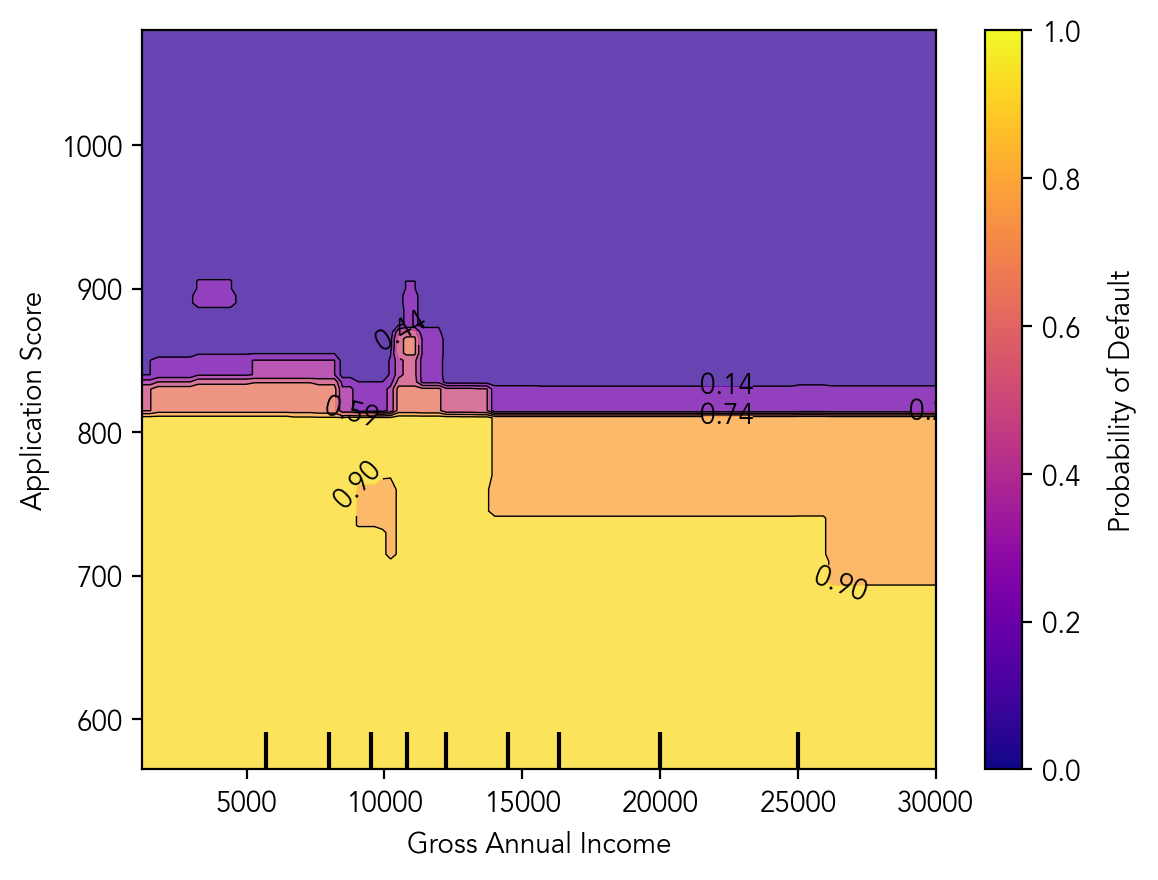

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRFClassifier

# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["figure.dpi"] = 200

np.random.seed(0)

feature1, feature2, label = "Gross Annual Income", "Application Score", "is_default"

random_indices = np.random.choice(df.index, size=1_000, replace=False)

X, y = (
    df[[feature1, feature2]].iloc[random_indices].astype(float),
    df[label].iloc[random_indices],
)
features = [(0, 1)]

clf = XGBRFClassifier(n_estimators=5, random_state=0).fit(X, y)

display = PartialDependenceDisplay.from_estimator(
    clf,
    X,
    features,
    grid_resolution=100,
    response_method="predict_proba",
    contour_kw={"cmap": "plasma"},
    random_state=0,
)

# Create colorbar manually
ax = display.axes_[0, 0]
norm = mcolors.Normalize(vmin=0, vmax=1)  # Assuming probabilities 0-1
sm = cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Probability of Default", labelpad=10)

## Observed dependence plots

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_61223/2484093687.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby([features[0], features[1]])[target_name]


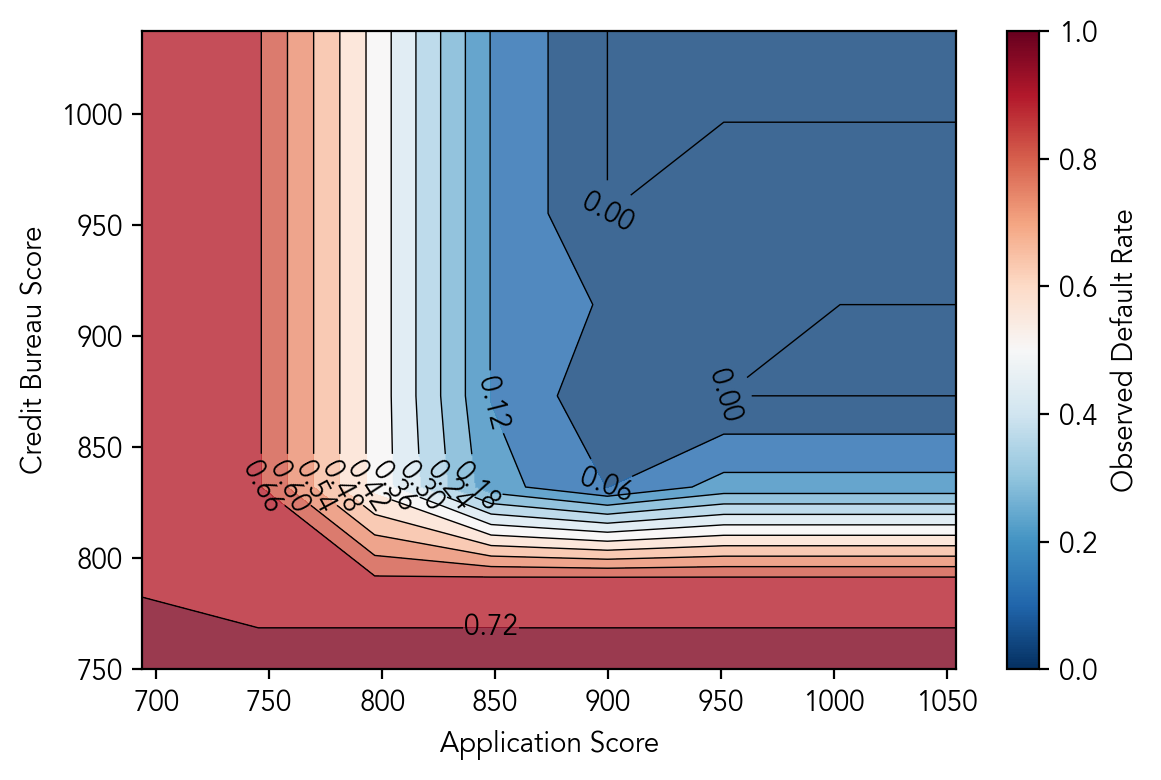

In [3]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["figure.dpi"] = 200
CMAP = "RdBu_r"
LEVELS = 12

np.random.seed(0)

feature1, feature2, label = "Credit Bureau Score", "Application Score", "is_default"

random_indices = np.random.choice(df.index, size=1_000, replace=False)

# Get the subset of data
subset_df = df.iloc[random_indices]


def create_observed_contour_plot(X, features, y, bins=10, min_samples_per_bin=5):
    """
    Create a contour plot with better handling of sparse data
    """
    # Apply binning to the features
    df_plot = X.copy()
    df_plot[features[0]] = pd.cut(df_plot[features[0]], bins=bins, precision=2)
    df_plot[features[1]] = pd.cut(df_plot[features[1]], bins=bins, precision=2)

    # Add the target variable to the plotting dataframe
    target_name = y.name if y.name is not None else "target"
    df_plot[target_name] = y.values

    # Calculate the average target values and count of observations
    grouped = (
        df_plot.groupby([features[0], features[1]])[target_name]
        .agg(["mean", "count"])
        .reset_index()
    )

    # Filter out bins with too few samples
    grouped = grouped[grouped["count"] >= min_samples_per_bin]

    # Pivot the data to create a 2D grid
    heatmap_data = grouped.pivot(index=features[0], columns=features[1], values="mean")

    if len(heatmap_data.columns) > 0:
        return _create_heatmap(heatmap_data, grouped, features)
    print("No valid data after filtering")
    return None, None


def _create_heatmap(heatmap_data, grouped, features):
    heatmap_data.columns = heatmap_data.columns.map(lambda x: x.mid)
    heatmap_data.index = heatmap_data.index.map(lambda x: x.mid)

    # Convert to numeric type and fill NaN values
    heatmap_data = heatmap_data.apply(pd.to_numeric)

    # Create contour plot with plasma colormap
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    # Only create contour if we have enough data
    if heatmap_data.notna().sum().sum() > 10:  # At least 10 valid data points
        # Fill NaN values with interpolation or remove them
        heatmap_data_filled = heatmap_data.interpolate(
            method="linear", axis=0
        ).interpolate(method="linear", axis=1)

        # Create contour plot
        contour = ax.contourf(
            heatmap_data_filled.columns,
            heatmap_data_filled.index,
            heatmap_data_filled.values,
            levels=LEVELS,
            cmap=CMAP,
            alpha=0.8,
        )

        # Add contour lines
        contour_lines = ax.contour(
            heatmap_data_filled.columns,
            heatmap_data_filled.index,
            heatmap_data_filled.values,
            levels=contour.levels,
            colors="black",
            alpha=1,
            linewidths=0.5,
        )

        # Add contour labels
        ax.clabel(contour_lines, inline=True, fontsize=10, fmt="%.2f")

    else:
        # If not enough data, create a simple scatter plot
        print("Not enough data for smooth contours, creating scatter plot instead")
        scatter_data = grouped.copy()
        scatter_data["x"] = scatter_data[features[1]].map(lambda x: x.mid)
        scatter_data["y"] = scatter_data[features[0]].map(lambda x: x.mid)

        ax.scatter(
            scatter_data["x"],
            scatter_data["y"],
            c=scatter_data["mean"],
            cmap=CMAP,
            s=scatter_data["count"] * 10,
            alpha=0.7,
        )

    # Set labels
    ax.set_xlabel(features[1])
    ax.set_ylabel(features[0])

    # Create colorbar
    norm = mcolors.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=CMAP, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Observed Default Rate", labelpad=5)

    return fig, ax


# Create the visualization with better handling
fig, ax = create_observed_contour_plot(
    subset_df[[feature1, feature2]],
    [feature1, feature2],
    subset_df[label],
    bins=10,  # Fewer bins to ensure enough samples per bin
    min_samples_per_bin=10,
)

plt.tight_layout()
plt.show()